## Import Library

In [15]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [16]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [17]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

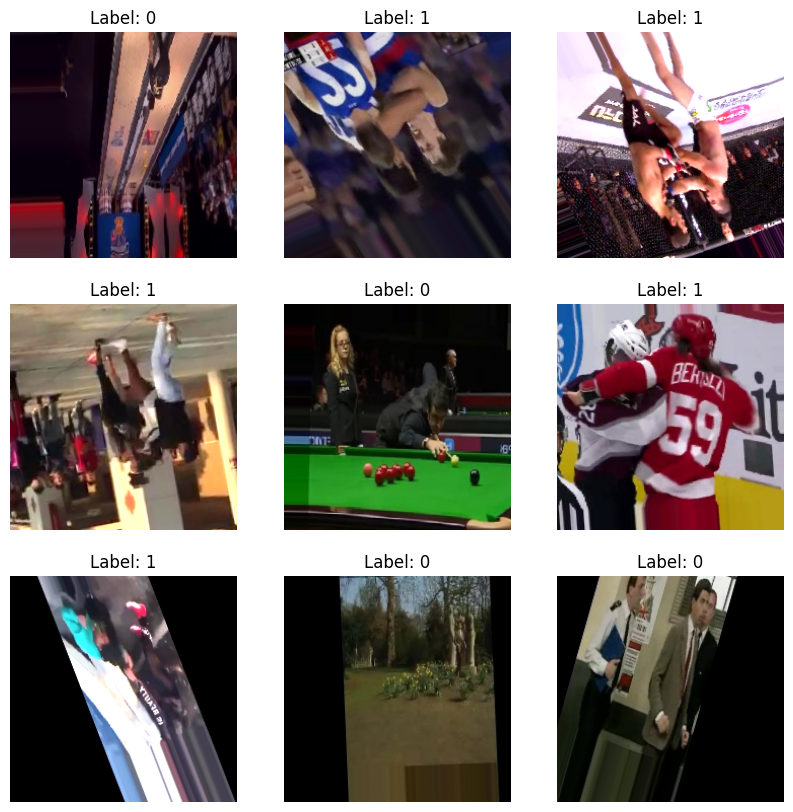

In [18]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [19]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze20_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [20]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5278 - loss: 1.4556
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 749ms/step - accuracy: 0.5286 - loss: 1.4542 - val_accuracy: 0.5000 - val_loss: 1.1839
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6208 - loss: 1.3156
Epoch 2: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 660ms/step - accuracy: 0.6213 - loss: 1.3143 - val_accuracy: 0.5000 - val_loss: 1.2238
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6703 - loss: 1.1851
Epoch 3: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.6705 - loss: 1.1843 - val_accuracy: 0.5000 - val_loss: 1.2436
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.6965 - loss: 1.0966
Epoch 4: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 670ms/step - accuracy: 0.6962 - loss: 1.0968 - val_accuracy: 0.5000 - val_loss: 1.2567
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.7228 - loss: 1.0414
Epoch 5: val_accuracy improved 

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 688ms/step - accuracy: 0.7230 - loss: 1.0409 - val_accuracy: 0.5023 - val_loss: 1.2102
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7308 - loss: 0.9849
Epoch 6: val_accuracy improved from 0.50227 to 0.53182, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 685ms/step - accuracy: 0.7308 - loss: 0.9851 - val_accuracy: 0.5318 - val_loss: 1.1030
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7335 - loss: 0.9920
Epoch 7: val_accuracy improved from 0.53182 to 0.64091, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.7336 - loss: 0.9917 - val_accuracy: 0.6409 - val_loss: 0.9824
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.7562 - loss: 0.9695
Epoch 8: val_accuracy improved from 0.64091 to 0.68864, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 669ms/step - accuracy: 0.7559 - loss: 0.9694 - val_accuracy: 0.6886 - val_loss: 0.9313
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7598 - loss: 0.9226
Epoch 9: val_accuracy improved from 0.68864 to 0.75455, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 669ms/step - accuracy: 0.7598 - loss: 0.9227 - val_accuracy: 0.7545 - val_loss: 0.8487
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7629 - loss: 0.9096
Epoch 10: val_accuracy improved from 0.75455 to 0.77500, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.7628 - loss: 0.9101 - val_accuracy: 0.7750 - val_loss: 0.7969
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7429 - loss: 0.9212
Epoch 11: val_accuracy improved from 0.77500 to 0.80000, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 673ms/step - accuracy: 0.7429 - loss: 0.9206 - val_accuracy: 0.8000 - val_loss: 0.7653
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7805 - loss: 0.8689
Epoch 12: val_accuracy improved from 0.80000 to 0.82727, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 693ms/step - accuracy: 0.7804 - loss: 0.8692 - val_accuracy: 0.8273 - val_loss: 0.7164
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7573 - loss: 0.8848
Epoch 13: val_accuracy improved from 0.82727 to 0.85455, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 661ms/step - accuracy: 0.7571 - loss: 0.8850 - val_accuracy: 0.8545 - val_loss: 0.6696
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7570 - loss: 0.8860
Epoch 14: val_accuracy improved from 0.85455 to 0.85909, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.7570 - loss: 0.8857 - val_accuracy: 0.8591 - val_loss: 0.6528
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.7812 - loss: 0.8615
Epoch 15: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.7812 - loss: 0.8617 - val_accuracy: 0.8545 - val_loss: 0.6561
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7776 - loss: 0.8285
Epoch 16: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 669ms/step - accuracy: 0.7777 - loss: 0.8285 - val_accuracy: 0.8591 - val_loss: 0.6469
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7935 - loss: 0.7952
Epoch 17: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 661ms/step - accuracy: 0.7935 - loss: 0.7955 - val_accuracy: 0.8455 - val_loss: 0.6699
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7931 - loss: 0.8196
Epoch 18: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 721ms/step - accuracy: 0.7897 - loss: 0.8242 - val_accuracy: 0.8636 - val_loss: 0.6443
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7681 - loss: 0.8590
Epoch 20: val_accuracy did not improve from 0.86364
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.7682 - loss: 0.8587 - val_accuracy: 0.8273 - val_loss: 0.7055
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8087 - loss: 0.7638
Epoch 21: val_accuracy did not improve from 0.86364
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 680ms/step - accuracy: 0.8084 - loss: 0.7647 - val_accuracy: 0.8068 - val_loss: 0.7360
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7891 - loss: 0.7833
Epoch 22: val_accuracy did not improve from 0.86364
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 658ms/step - accuracy: 0.7891 - loss: 0.7835 - val_accuracy: 0.8250 - val_loss: 0.6944
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8040 - loss: 0.7903
Epoch 23: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.7948 - loss: 0.7652 - val_accuracy: 0.8727 - val_loss: 0.6191
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7926 - loss: 0.7687
Epoch 26: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.7926 - loss: 0.7689 - val_accuracy: 0.8636 - val_loss: 0.6212
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8082 - loss: 0.7373
Epoch 27: val_accuracy improved from 0.87273 to 0.88182, saving model to NoMCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 674ms/step - accuracy: 0.8078 - loss: 0.7381 - val_accuracy: 0.8818 - val_loss: 0.6038
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8088 - loss: 0.7384
Epoch 28: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 662ms/step - accuracy: 0.8089 - loss: 0.7381 - val_accuracy: 0.8659 - val_loss: 0.5992
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8131 - loss: 0.7118
Epoch 29: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 723ms/step - accuracy: 0.8130 - loss: 0.7124 - val_accuracy: 0.8682 - val_loss: 0.6088
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8017 - loss: 0.7740
Epoch 30: val_accuracy did not improve from 0.88182
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.8018 - loss: 0.7735 - val_accuracy: 0.8318 - val_loss: 0.6679
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8130 - loss: 0.7370
Epoch 31: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 723ms/step - accuracy: 0.7991 - loss: 0.7473 - val_accuracy: 0.8864 - val_loss: 0.5794
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8134 - loss: 0.7291
Epoch 37: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 656ms/step - accuracy: 0.8136 - loss: 0.7286 - val_accuracy: 0.8659 - val_loss: 0.5966
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8235 - loss: 0.7297
Epoch 38: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.8234 - loss: 0.7295 - val_accuracy: 0.8727 - val_loss: 0.5865
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8383 - loss: 0.6750
Epoch 39: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 683ms/step - accuracy: 0.8380 - loss: 0.6755 - val_accuracy: 0.8773 - val_loss: 0.5635
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8190 - loss: 0.7022
Epoch 40: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.8060 - loss: 0.6956
Validation Loss: 0.5741597414016724
Validation Accuracy: 0.8681818246841431


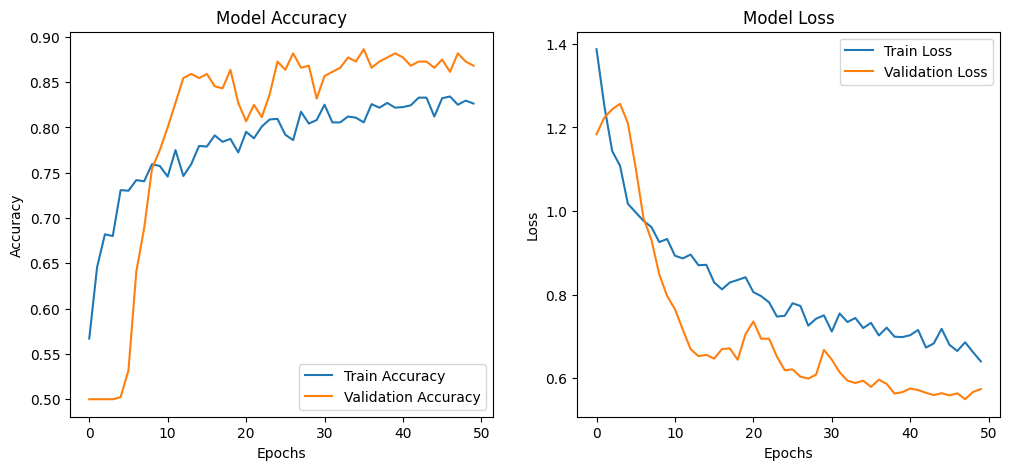

In [21]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [22]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze20_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.8145 - loss: 0.7410
Test Accuracy : 87.84%
Test Loss     : 0.603


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step


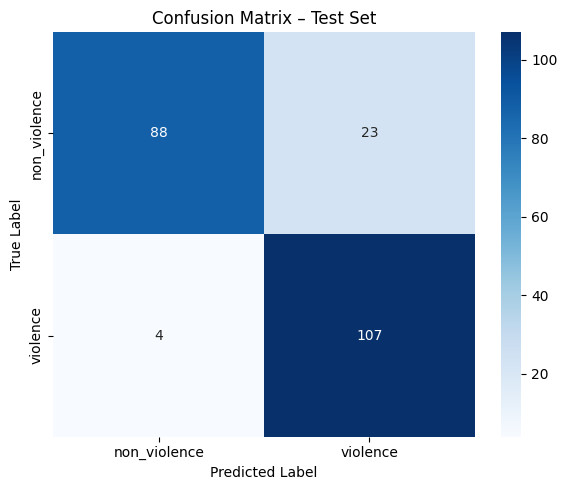


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.96      0.79      0.87       111
    violence       0.82      0.96      0.89       111

    accuracy                           0.88       222
   macro avg       0.89      0.88      0.88       222
weighted avg       0.89      0.88      0.88       222



In [23]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))